In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


#use random forrest to imput age
from sklearn.ensemble import RandomForestRegressor
import sklearn.preprocessing as preprocessing

def set_missing_age(df):
    age_df = df[['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']]
    
    known_age = age_df[age_df['Age'].notnull()].values
    unknown_age = age_df[age_df['Age'].isnull()].values
    
    #age column
    y = known_age[:,0]
    #other attributes
    x = known_age[:,1:]
    
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(x,y)
    
    predictedAges = rfr.predict(unknown_age[:,1:])
    
    df.loc[(df['Age'].isnull()), 'Age'] = predictedAges
    
    return df, rfr


def set_Cabin_type(df):
    df.loc[ (df['Cabin'].notnull()), 'Cabin' ] = "Yes"
    df.loc[ (df['Cabin'].isnull()), 'Cabin' ] = "No"
    return df

def scale_standard_columns(col_names, df):
    scaler = preprocessing.StandardScaler()
    df[col_names] = scaler.fit_transform(df[col_names].values.reshape(-1,len(col_names)))
    return df

def convert_categorical_feature_to_bool_column(col_names, df):
    for i in col_names:
        dummies_col = pd.get_dummies(df[i], prefix= i)
        df = pd.concat([df,dummies_col], axis=1)
    
    df.drop(col_names, axis=1, inplace=True)
    return df

data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

data_train, rfr = set_missing_age(data_train)
data_train = set_Cabin_type(data_train)
data_train = scale_standard_columns(['Age', 'Fare'], data_train)
data_train = convert_categorical_feature_to_bool_column(['Pclass', 'Sex', 'Cabin', 'Embarked'], data_train)
data_train.drop(['Name', 'Ticket'], axis=1, inplace=True)

data_test.loc[ (data_test['Fare'].isnull()), 'Fare' ] = 0
data_test, rfr = set_missing_age(data_test)
data_test = set_Cabin_type(data_test)
data_test = scale_standard_columns(['Age', 'Fare'], data_test)
data_test = convert_categorical_feature_to_bool_column(['Pclass', 'Sex', 'Cabin', 'Embarked'], data_test)
data_test.drop(['Name', 'Ticket'], axis=1, inplace=True)

In [17]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6, solver='liblinear', multi_class='auto', max_iter=1000)
all_data = data_train.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Sex_.*|Pclass_.*')
X = all_data.values[:,1:]
y = all_data.values[:,0]
print (cross_val_score(clf, X, y, cv=5))

[0.81005587 0.81005587 0.80337079 0.76404494 0.80225989]


<module 'matplotlib.pyplot' from '/home/jgao/.conda/envs/kaggle/lib/python3.7/site-packages/matplotlib/pyplot.py'>

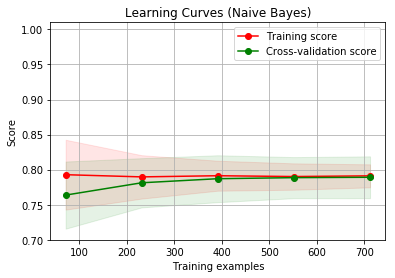

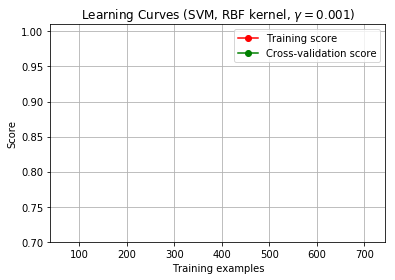

In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

In [22]:
from sklearn.ensemble import BaggingRegressor

train_df = data_train.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Sex_.*|Pclass_.*')
train_np = train_df.values

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

# fit到RandomForestRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6, solver='liblinear', multi_class='auto', max_iter=1000)
bagging_clf = BaggingRegressor(clf, n_estimators=20, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagging_clf.fit(X, y)

print(bagging_clf)

test = data_test.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Sex_.*|Pclass_.*')
predictions = bagging_clf.predict(test.values)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].values, 'Survived':predictions.astype(np.int32)})
result.to_csv("logistic_regression_predictions.csv", index=False)

BaggingRegressor(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='auto',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=1e-06, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=20, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)
